In [1]:
import intake
import xarray as xr
import numpy as np
import pandas as pd
import scipy
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import tqdm
import hvplot.xarray
from IPython.display import Image

def get_intake_cat():

    '''
    Return the intake catalog for barra
    '''

    #See here: https://opus.nci.org.au/pages/viewpage.action?pageId=264241965
    data_catalog = intake.open_esm_datastore("/g/data/ob53/catalog/v2/esm/catalog.json")

    return data_catalog

def load_barra_static(domain_id,lon_slice,lat_slice):

    '''
    For a barra domain, load static variables
    domain_id: for barra, either AUS-04 or AUST-11
    lat_slice: a slice to restrict lat domain
    lon_slice: a slice to restrict lon domain
    '''

    data_catalog = get_intake_cat()
    orog = data_catalog.search(variable_id="orog",domain_id=domain_id).to_dask().sel(lon=lon_slice, lat=lat_slice)
    lsm = data_catalog.search(variable_id="sftlf",domain_id=domain_id).to_dask().sel(lon=lon_slice, lat=lat_slice)

    return orog.orog, (lsm.sftlf >= 0.5) * 1

In [2]:
lat_slice = slice(-45,-5)
lon_slice = slice(110,155)
orog, lsm = load_barra_static("AUS-11",lon_slice,lat_slice)

In [3]:
def get_coastline_angle_circle(coast_label, land_label, lsm):

    '''
    Ewan and Jarrah's method. Construct a "kernel" for each coastline point to all other points, then average. Done separately for each landmass

    Input
    label: a labelled coastline array
    lsm: xarray dataarray with a binary lsm, and lat lon info

    Output
    an array of coastline angles (0-360 degrees from N) for the labelled coastline array
    '''

    lon = lsm.lon.values
    lat = lsm.lat.values
    xx,yy = np.meshgrid(lon,lat)
    xx = xx.astype(np.float16)
    yy = yy.astype(np.float16)    

    #Define coastline x,y indices from the coastline mask
    xl, yl = np.where(coast_label)

    #Get coastline lat lon vectors
    yy_t = np.array([yy[xl[t],yl[t]] for t in np.arange(len(yl))])
    xx_t = np.array([xx[xl[t],yl[t]] for t in np.arange(len(xl))])

    #Repeat the 2d lat lon array over a third dimension (corresponding to the coast dim)
    yy_rep=np.repeat(yy[:,:,np.newaxis],yl.shape[0],axis=2)
    xx_rep=np.repeat(xx[:,:,np.newaxis],xl.shape[0],axis=2)
    stack = np.zeros(xx_rep.shape,dtype=np.complex64)
    for t in tqdm.tqdm(range(yl.shape[0])):
        stack[:,:,t] = (yy_rep[:,:,t] - yy_t[t])*1j + (xx_rep[:,:,t] - xx_t[t])    
    
    #Compute the differences in complex space over all coastline points. Reorder for to work with the array easier
    stack = np.moveaxis(stack, -1, 0)
    
    #Create an inverse distance weighting function
    weights = ((1/(np.abs(stack)))**4).astype(np.float16)

    #Take the weighted mean and convert complex numbers to an angle
    mean_angles = np.mean( (weights * stack) , axis=0)
    mean_angles = np.angle(mean_angles)    

    #Flip the angles inside the coastline for convention, and convert range to 0 to 2*pi
    mean_angles = np.where(land_label==1,(mean_angles+np.pi) % (2*np.pi),mean_angles % (2*np.pi))
    
    #Calculate the weighted circular variance
    total_weight = np.sum(weights, axis=0)
    weights = weights/total_weight
    stack = stack / np.abs(stack)
    variance = 1 - np.abs(np.sum(weights*stack, axis=0))  

    #Reverse the angles for consistency with previous methods, and convert to degrees
    mean_angles = -np.rad2deg(mean_angles) + 360
    return mean_angles, stack, variance
    
mean_angles, stack, variance = get_coastline_angle_circle(find_boundaries(lsm)*1, lsm.values, lsm)

100%|██████████| 6782/6782 [02:05<00:00, 53.88it/s]
/jobfs/126606884.gadi-pbs/ipykernel_1337703/2700962772.py:38: RuntimeWarning: divide by zero encountered in divide
  weights = ((1/(np.abs(stack)))**4).astype(np.float16)
/jobfs/126606884.gadi-pbs/ipykernel_1337703/2700962772.py:41: RuntimeWarning: invalid value encountered in multiply
  mean_angles = np.mean( (weights * stack) , axis=0)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/jobfs/126606884.gadi-pbs/ipykernel_1337703/2700962772.py:49: RuntimeWarning: invalid value encountered in divide
  weights = weights/total_weight
/jobfs/126606884.gadi-pbs/ipykernel_1337703/2700962772.py:50: RuntimeWarning: invalid value encountered in divide
  stack = stack / np.abs(stack)


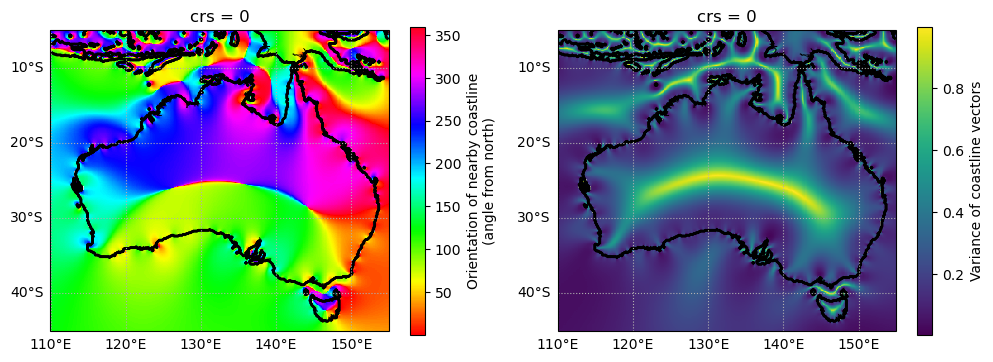

In [4]:
plt.figure(figsize=[12,4])
lon = lsm.lon
lat = lsm.lat
angle_da = xr.DataArray(mean_angles,coords={"lat":lat,"lon":lon})
var_da = xr.DataArray(variance,coords={"lat":lat,"lon":lon})

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
c=angle_da.plot(cmap="hsv",add_colorbar=False)
xr.plot.contour(lsm,colors=["k"])
cb=plt.colorbar(c)
ax.coastlines(lw=0.4)
ax.gridlines(draw_labels=["left","bottom"],ls=":")
cb.set_label("Orientation of nearby coastline\n(angle from north)")

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
c=var_da.plot(add_colorbar=False)
xr.plot.contour(lsm,colors=["k"])
cb=plt.colorbar(c)
ax.coastlines(lw=0.4)
ax.gridlines(draw_labels=["left","bottom"],ls=":")
cb.set_label("Variance of coastline vectors")

## Compare angles with method that calculates angles from neighbouring coastal points

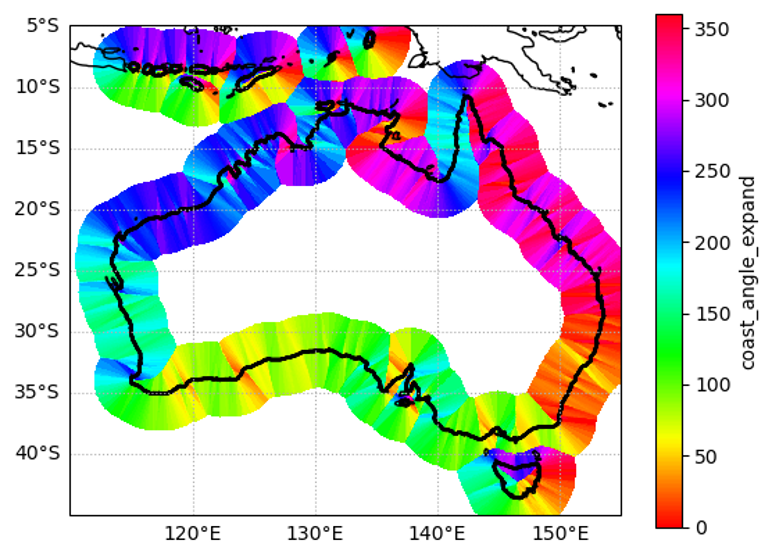

In [5]:
Image(filename='/home/548/ab4502/working/sea_breeze/figs/aus_coast_fit.png') 

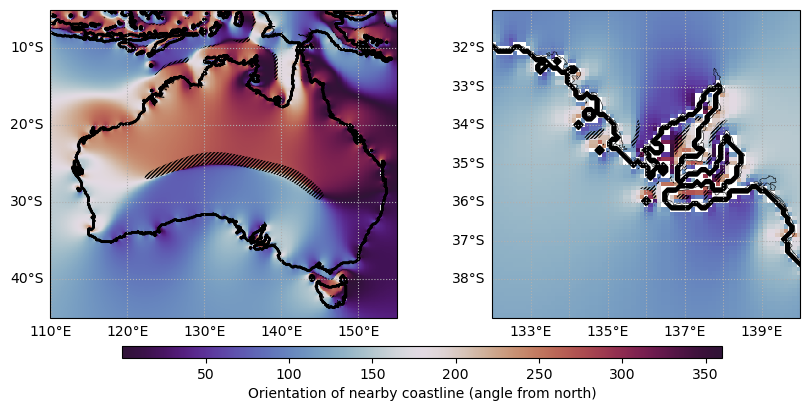

In [6]:
plt.figure(figsize=[10,4])

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
c=angle_da.plot(cmap="twilight_shifted",add_colorbar=False)
xr.plot.contour(lsm,colors=["k"])
xr.plot.contourf(var_da,levels=[0.,0.8],hatches=["","/////////"],colors="none",add_colorbar=False)
ax.coastlines(lw=0.4)
ax.gridlines(draw_labels=["left","bottom"],ls=":")
plt.title("")

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
c=angle_da.plot(cmap="twilight_shifted",add_colorbar=False)
xr.plot.contourf(var_da,levels=[0.,0.5],hatches=["","/////////"],colors="none",add_colorbar=False)
xr.plot.contour(lsm,colors=["k"])
ax.coastlines(lw=0.4)
ax.gridlines(draw_labels=["left","bottom"],ls=":")
# ax.set_xlim([120,135])
# ax.set_ylim([-20,-5])
ax.set_xlim([132,140])
ax.set_ylim([-39,-31])
plt.title("")

cax=plt.axes([0.2,0.01,0.6,0.03])
cb=plt.colorbar(c,cax=cax,orientation="horizontal")
cb.set_label("Orientation of nearby coastline (angle from north)")

In [11]:
angle_da.hvplot(cmap="twilight_shifted",width=800,height=800)

:Image   [lon,lat]   (value)